Code to simulate straining of the Fibre Bragg Grating  
Written by: Samhita S Sodhi (16/05/24)

This notebook contains the same code from newSimulatingCode_FBG.ipynb **BUT** is a draft/scratch notebook used to test code

In [1]:
import sys
sys.path.insert(0, ".")

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from funcs import *

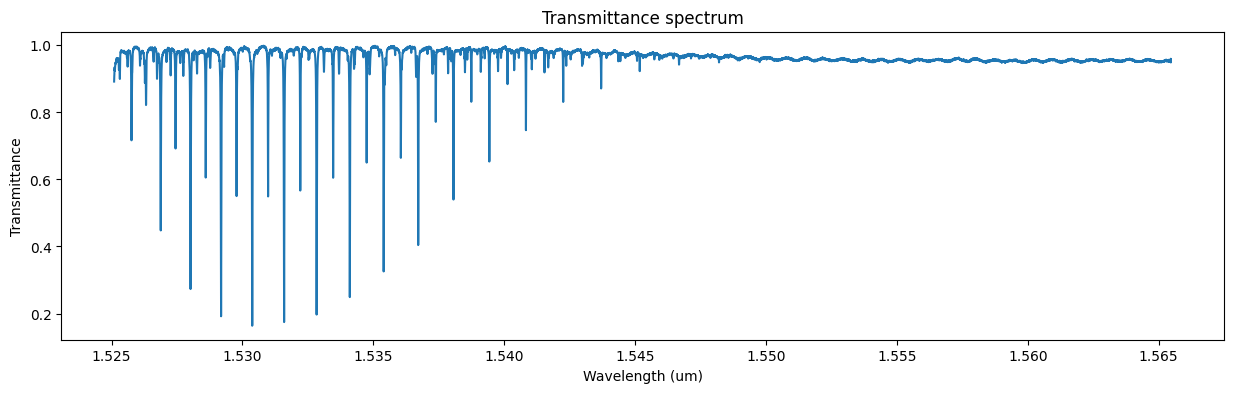

In [2]:
# Testing function using generated data from NASA PSG
spectra_wav, spectra_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/C2H2 gas cell-_40nm_1_T_C33-c2h2200C3M_42nm_0_T.txt', 0, 2, "\t", None, "nm", "dB")
plot_spectra(spectra_wav, spectra_data)
transmittance = fit_curves(spectra_wav, spectra_data, 0.09, 'lorentzian')

In [3]:
## Probability i.e., what is the probability light will make it through the core and how long this will take

# sunlight = (1.366e3)*u.W/(u.m)**2  # over the entire EM spectrum
# area_of_fibre_core = 5.03e-11*(u.m)**2
# area_of_square = 1*((u.m)**2)

# probability_light_gets_through = area_of_fibre_core/area_of_square
# print(probability_light_gets_through)

# amount_of_light_that_gets_through = probability_light_gets_through * sunlight
# print(amount_of_light_that_gets_through)

# percentage_of_total_sunlight = amount_of_light_that_gets_through / sunlight * 100
# print(percentage_of_total_sunlight)

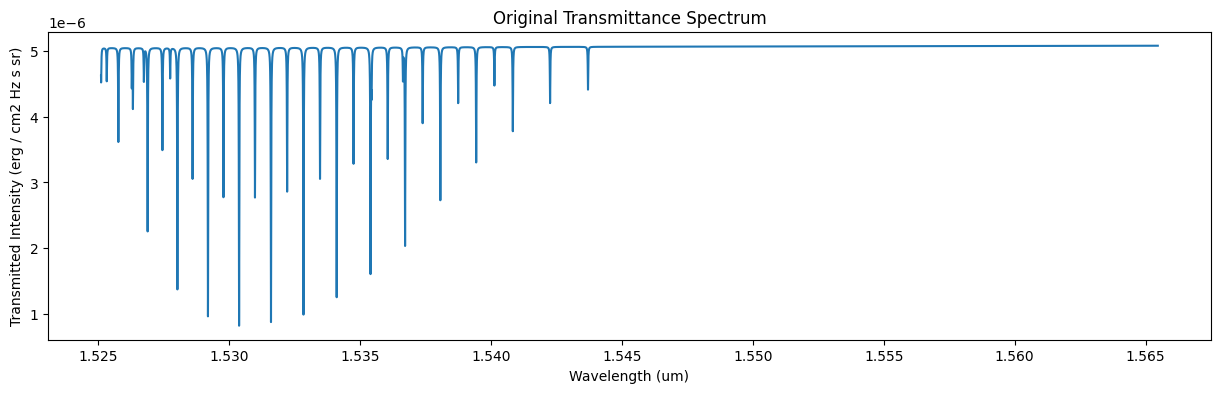

In [4]:
# imprinting a blackbody curve onto the gas

flux, transmitted_intensity = blackbodyabsorption(spectra_wav, transmittance, 3000)
plot_spectra(spectra_wav, transmitted_intensity, title = 'Original Transmittance Spectrum', yaxislabel = 'Transmitted Intensity (erg / cm2 Hz s sr)')

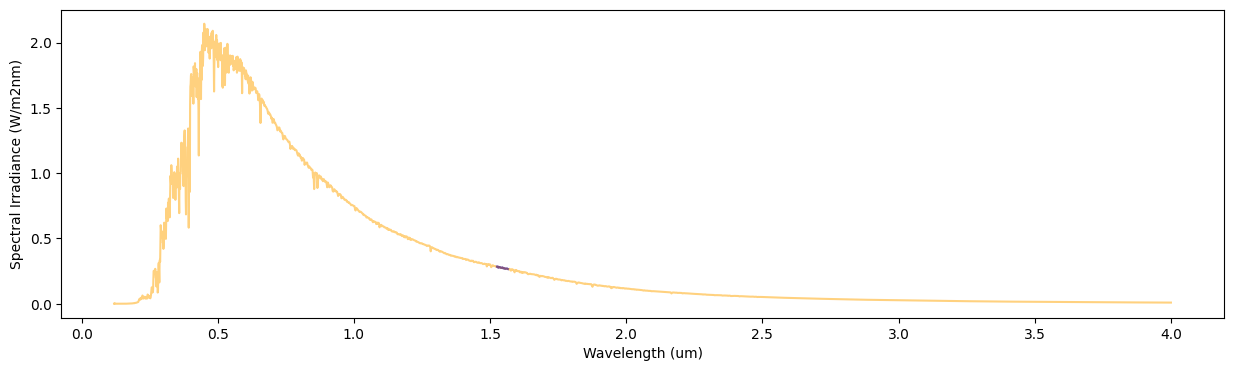

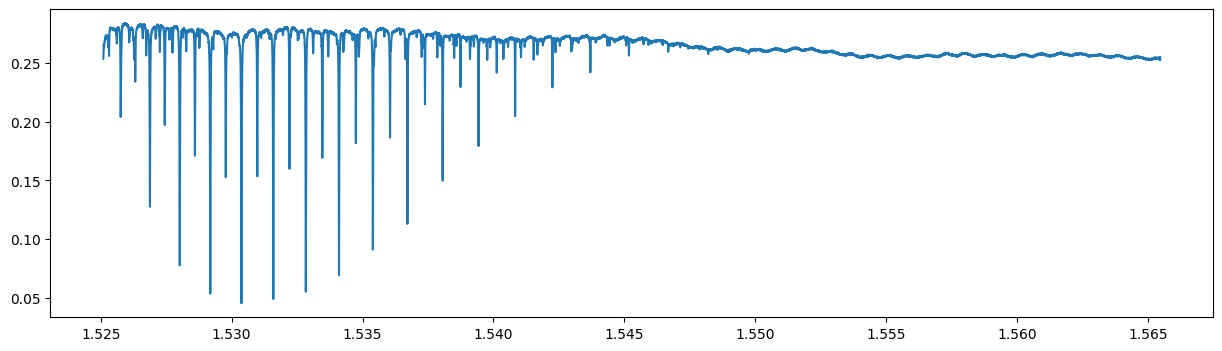

Area under the solar spectrum is: 1354.34699305


In [5]:
## sunlight https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html#:~:text=The%20American%20Society%20for%20Testing,set%20of%20specified%20atmospheric%20conditions.
##          https://www.pveducation.org/pvcdrom/appendices/standard-solar-spectra


#### imprinting a more realistic solar spectrum onto the gas
 

sunlight_raw_data = pd.read_csv('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/New Code/sun data.txt', header = None, sep = "\t").values  
sunlight_wavelength = (sunlight_raw_data[:,0]).astype(float) / 1000.0
sunlight_line_data = (sunlight_raw_data[:,1]).astype(float)

interpolating_func = interp1d(sunlight_wavelength, sunlight_line_data, kind='linear')
increase_datavals = interpolating_func(spectra_wav)

figure(figsize=(15,4))
plt.plot(spectra_wav, increase_datavals, c = 'b')
plt.plot(sunlight_wavelength, sunlight_line_data, alpha = 0.5, c = 'orange')
# plt.xlim([1.5, 1.6])
# plt.ylim([0.0, 0.5])
plt.ylabel('Spectral Irradiance (W/m2nm)')
plt.xlabel('Wavelength (um)')
plt.show()


#### Imprinting the gas spectra onto the solar spectrum (y-axis could be wrong)
imprint_gas_to_sun_spectra = increase_datavals * spectra_data

figure(figsize=(15,4))
plt.plot(spectra_wav, imprint_gas_to_sun_spectra)
plt.xlabel('Wavelength (um)')
plt.show()



#### testing to see whether the area under the solar spectrum can be supported by online sources of the solar constant 
area = np.trapz(sunlight_line_data, sunlight_wavelength*1000)

print('Area under the solar spectrum is:' + ' ' + str(area))
# ~927.0070705500001 W/m2        (without x values)
# ~1354.34699305 W/m2            (with x values)

#Aligns with the value given online ~1366 W/m2

testing to see whether the gaussian and lorentzian model fits the data better 

appears neither does so, may require a convolution of the two (Voigt model) !!!


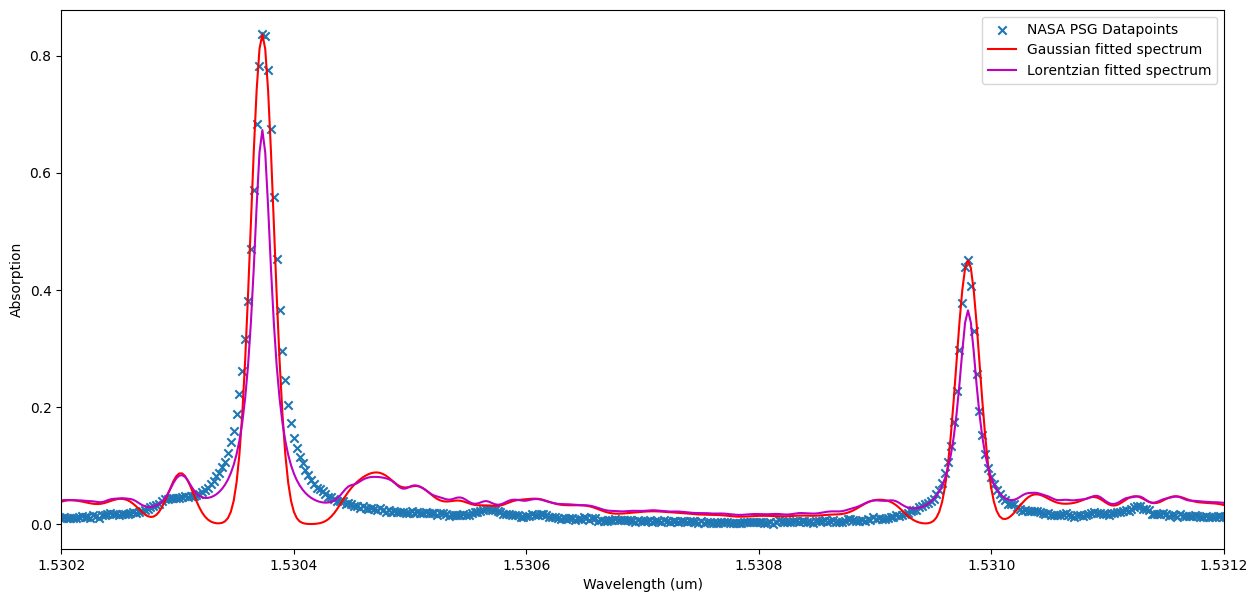

In [6]:
x_values = np.array(spectra_wav)
y_values = np.array(1.0 - spectra_data) #converting to absorption sepctrum so function can find peaks

peaks, properties  = find_peaks(y_values, height=0.000010, width = 0) #properties include, peak heights, peak widths, etc. 

# --- GAUSSIAN
def gaussian(x, sigma, mu, amp):
  return amp*1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2/(2*sigma**2))

peak = np.array(x_values[peaks]) #since peaks is an array of indexes, associating each index to it's wavelength value
widths = 0.00001
amps = np.array(properties['peak_heights']) #array of all the heights
# widths = np.array(properties['widths'])

x = np.array(spectra_wav)
y_g = np.zeros(x.shape) 

for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
    g = gaussian(x, sigma=widths, mu=peak[i], amp=amps[i]) #fit this gaussian
    y_g += g

scale = max(y_g)/max(properties['peak_heights'])
amps_scaled = np.array(properties['peak_heights']) / scale #array of all the heights

y_gscaled = np.zeros(x.shape) 

for i in range(len(peaks)): #for each peak in the range of the length of the number of peaks... 
    g = gaussian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i]) #fit this gaussian
    y_gscaled += g



# --- LORENTZIAN
def lorentzian(x, sigma, mu, amp):
    return (amp/np.pi) * (sigma/((x-mu)**2 + sigma**2))

y_l = np.zeros(x.shape) 

for i in range(len(peaks)):
    lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps[i])
    y_l += lor

scale_l = max(y_l)/max(properties['peak_heights'])
amps_scaled_l = np.array(properties['peak_heights']) / scale_l #array of all the heights

y_lscaled = np.zeros(x.shape) 

for i in range(len(peaks)):
    lor = lorentzian(x, sigma=widths, mu=peak[i], amp=amps_scaled[i])
    y_lscaled += lor

figure(figsize=(15, 7))
plt.scatter(x_values, y_values, marker = 'x')
plt.plot(x, y_gscaled, color = 'r')
plt.plot(x, y_lscaled, color = 'm')
plt.xlim([1.5302, 1.5312])
plt.xlabel('Wavelength (um)')
plt.ylabel('Absorption')
plt.legend(['NASA PSG Datapoints', 'Gaussian fitted spectrum', 'Lorentzian fitted spectrum'])
plt.show()

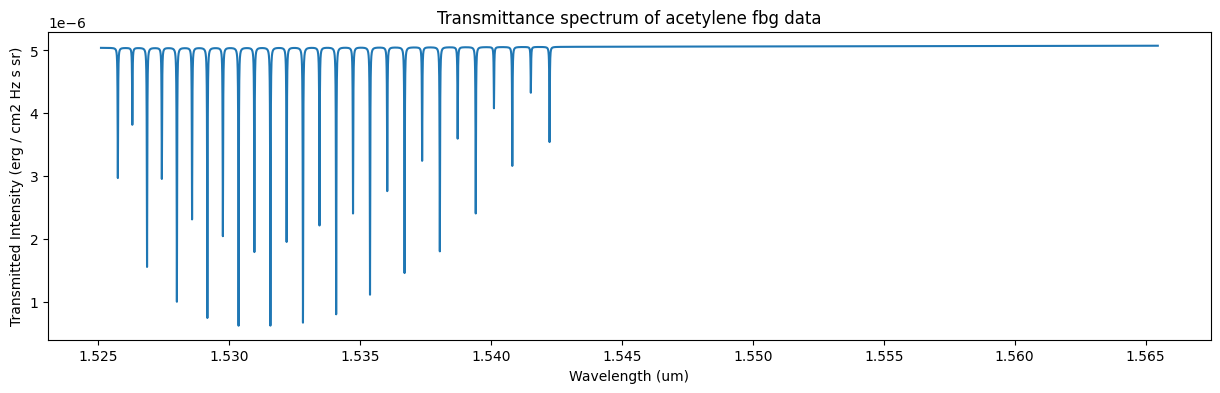

In [7]:
#Loading the fibre grating data for the simulation
fibre_wavelength, fibregrating_line_data = input_spectra('/home/samhitasodhi/Gas Sensor Project/Code - Nicholas Morley/fbg_prog/fbg_prog/Line_Lists/FBG_C33-c2h2200C3M_42nm_0_T.txt', 0, 2, '\t', None, "nm", "dB")
transmittanceFBG = fit_curves(fibre_wavelength, fibregrating_line_data, 0.09, 'lorentzian')
fluxFBG, transmitted_intensityFBG = blackbodyabsorption(fibre_wavelength, transmittanceFBG, 3000)
plot_spectra(spectra_wav, transmitted_intensityFBG, title = 'Transmittance spectrum of acetylene fbg data', yaxislabel = 'Transmitted Intensity (erg / cm2 Hz s sr)')

In [8]:
fibre_wavelength_new, interpolatedvals = apply_strain(0.0005, [spectra_wav, fibre_wavelength], [transmitted_intensity, transmitted_intensityFBG], 0, 0.55e-6, 8.6e-6, 0.22) #values for silica, no temperature change

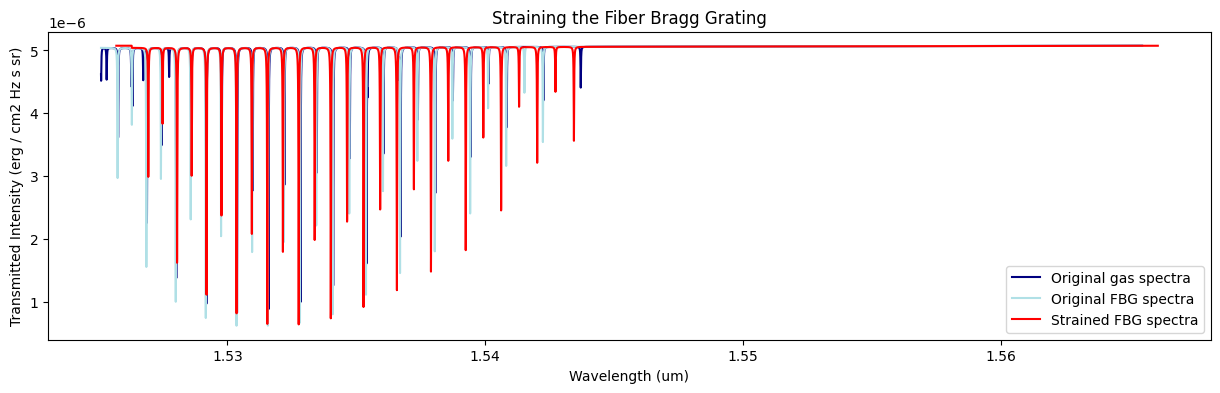

In [9]:
plot_strainspectra([spectra_wav, fibre_wavelength, fibre_wavelength_new], [transmitted_intensity, transmitted_intensityFBG, interpolatedvals])

In [10]:
# ~~~~~ Alison code 
# reflectedvals = []
# transmittedvals = []

# # for i in np.linspace(3.5e-4, 6e-4, 3):
# for i in [4.8e-4, 6.5e-4]:
#     fibre_wavelength_new, interpolatedvals = visualise_strain('acetylene gas', i, 0, 0.55e-6, 8.6e-6, 0.22) #values for silica, no temperature change
#     reflectedvals.append(reflected)
#     transmittedvals.append(transmitted)

# plt.plot(reflectedvals)
# plt.plot(transmittedvals)
# plt.plot(reflectedvals+transmittedvals)
# plt.show()

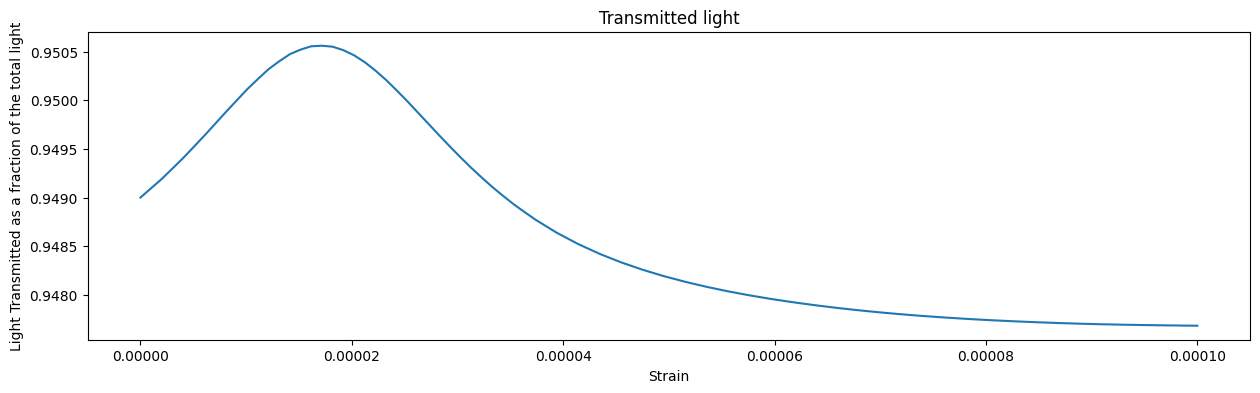

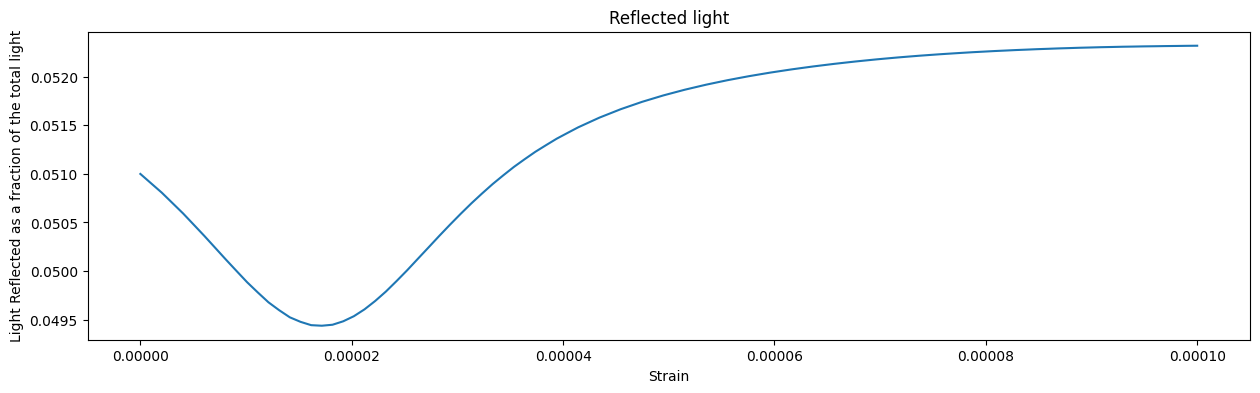

Total light (erg / cm2 Hz s sr): 1.0


In [13]:
### True values
# strain = np.linspace(0, 0.0007, 100) # takes a long time to run, else conversion to photoncounts does not work - wav, data different sizes! 
# transmittedlight, reflectedlight = correlation(strain, [spectra_wav, fibre_wavelength], spectra_data, [transmitted_intensity, transmitted_intensityFBG], 'False')


### Normalised values
strain = np.linspace(0, 0.0001, 100)
transmittedlightNorm, reflectedlightNorm = correlation(strain, [spectra_wav, fibre_wavelength], spectra_data, [transmitted_intensity, transmitted_intensityFBG], 'True')

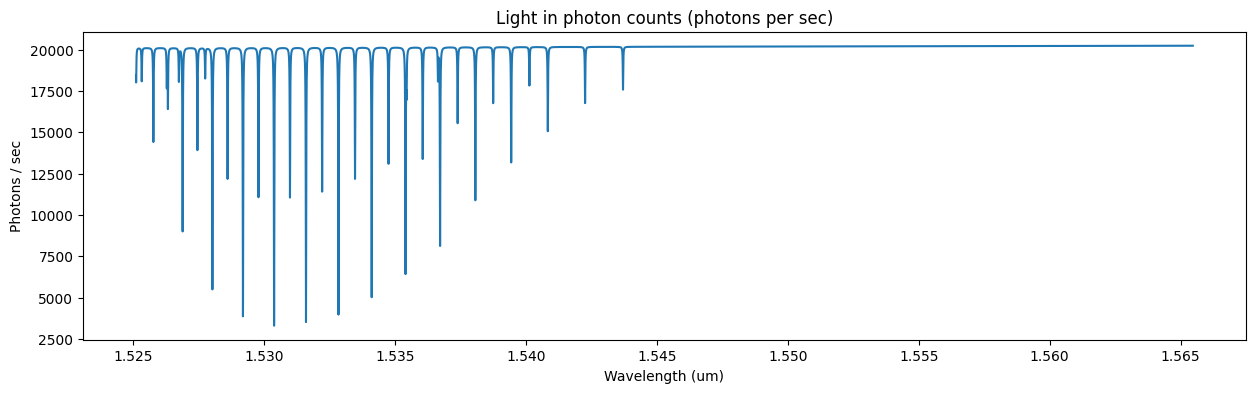

In [12]:
#testing unit conversion function
photoncount_persec = convert_fluxunits_to_photoncounts(spectra_wav, transmitted_intensity, 0.35, 0.000000503, 0.045, None, None)